## Theoretical motivation

Let $\{x^{(i)},y^{(i)}\}_{i \in 1:N}$ be our training set, where features $x^{(i)} \in \mathbb{R}^n$, and we assume $y^{(i)} \in \{-1,+1\}$ for all $i$ - standard binary classification problem. We call $F = \{1, 2,\ldots, n\}$ the set of all features.

Let $$L_{w,b}[\{x^{(i)},y^{(i)}\}_{i\in 1:N}] := \sum_{i=1}^N \max[0, -y^{(i)} (w\cdot x^{(i)} + b)]$$ be the **perceptron loss** for parameters $w \in \mathbb{R}^n, b \in \mathbb{R}$. 

We now assume a family of $2^n$ models (of any kind, eg. boosted trees or neural networks) $f_S: \mathbb{R}^{|S|} \to [0,1]$ has been trained via empirical risk minimization to map features $x_S$ (where $S$ here stands for a subset of all features, $S \subset F$, and $x_S$ is the restriction of $x$ to only these features) to probabilities of being $-1,1$. Collectivelly denote these models as $f$. We can then build the SHAP map $\phi: \mathbb{R}^n \to \mathbb{R}^n$ where

$$\phi_f(x)_j = \sum_{S \subset F \backslash \{j\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} (f_{S \cup \{j\}}(x_{S\cup \{j\}}) - f_S (x_S))$$

**Conjecture**: under the specifications above, for any $f$ obtained via empirical risk minimization,
$$\min_{w,b}L_{w,b}[\{x^{(i)},y^{(i)}\}_{i\in 1:N}] \geq \min_{w,b}L_{w,b}[\{\phi_f(x^{(i)}),y^{(i)}\}_{i\in 1:N}]$$

This would mean that the SHAP space is more linearly separable.

In [25]:
# install outside VPN
# !pip install --user shap 
#%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE

# Experimentação 

In [6]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           random_state=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=0.5)

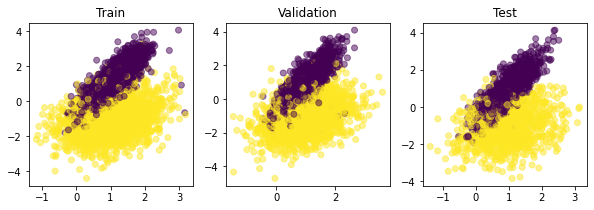

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))

ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.5)
ax[0].set_title("Train")

ax[1].scatter(X_val[:,0], X_val[:,1], c=y_val, alpha=0.5)
ax[1].set_title("Validation")

ax[2].scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.5)
ax[2].set_title("Test")
plt.show()

1. Fit linear model

In [12]:
%%time
lin_model = Perceptron(n_jobs=-1)
lin_model.fit(X_train, y_train)

CPU times: user 4.39 ms, sys: 1.94 ms, total: 6.34 ms
Wall time: 4.39 ms


Perceptron(n_jobs=-1)

In [13]:
lin_model.score(X_test, y_test)

0.851

2. Fit good model

In [14]:
model = RandomForestClassifier(n_estimators=300, )
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [15]:
model.score(X_test, y_test)

0.893

3. Now build SHAP

In [16]:
explainer = shap.TreeExplainer(model)

In [17]:
%%time
# note: use validation here
shap_val, shap_test = explainer(X_val), explainer(X_test)

CPU times: user 54.5 s, sys: 349 ms, total: 54.8 s
Wall time: 54.8 s


In [22]:
shap_val_vals = shap_val.values[:,:,1]
shap_test_vals = shap_test.values[:,:,1]

In [23]:
assert shap_val_vals.shape == X_val.shape

4. Train linear model here

In [24]:
%%time
lin_model_shap = Perceptron(n_jobs=-1)
lin_model_shap.fit(shap_val_vals, y_val)

CPU times: user 2.54 ms, sys: 1.12 ms, total: 3.67 ms
Wall time: 2.54 ms


Perceptron(n_jobs=-1)

In [25]:
lin_model_shap.score(shap_test_vals, y_test)

0.8795

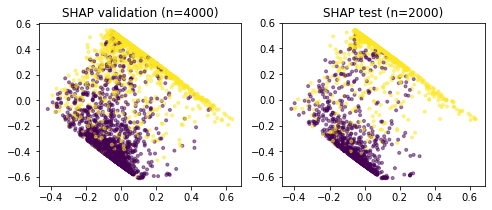

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))

ax[0].scatter(shap_val_vals[:,0], shap_val_vals[:,1], c=y_val, alpha=0.5, marker='.')
ax[0].set_title(f"SHAP validation (n={len(shap_val_vals)})")

ax[1].scatter(shap_test_vals[:,0], shap_test_vals[:,1], c=y_test, alpha=0.5, marker='.')
ax[1].set_title(f"SHAP test (n={len(shap_test_vals)})")

# x = np.arange(-0.4, 0.6, 0.01)
# ax[0].plot(x, 1/2-x, color='black')
# ax[0].plot(x, -1/2-x, color='black')

# ax[1].plot(x, 1/2-x, color='black')
# ax[1].plot(x, -1/2-x, color='black')
plt.show()

# Make into function

In [13]:
def shap_linear_separation_test(X, y, 
                                tree_model=RandomForestClassifier(n_estimators=300),
                                linear_model1=Perceptron(n_jobs=-1),
                                linear_model2=Perceptron(n_jobs=-1),
                                train_size=0.5,
                                val_size=0.25,
                                test_size=0.25,
                                plot=True
                               ):

    # separate datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=val_size/(train_size+val_size))
    
    
    # first linear model (base space)
    lin_model = linear_model1
    lin_model.fit(X_train, y_train)
    
    # nonlinear model (base space)
    tree_model.fit(X_train, y_train)
    
    # calculate SHAPs; here we drop X_train
    
    X_val, y_val = np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val])
    
    explainer = shap.TreeExplainer(tree_model)
    shap_val, shap_test = explainer(X_val), explainer(X_test)
    
    shap_val_vals = shap_val.values[:,:,1]
    shap_test_vals = shap_test.values[:,:,1]
    
    # second linear model (SHAP space)
    lin_model_shap = linear_model2
    lin_model_shap.fit(shap_val_vals, y_val)
    
    # scores
    print("Test set performances:")
    print(f"  > Tree model - base space: {tree_model.score(X_test, y_test)}")
    print(f"  > Linear model - base space: {lin_model.score(X_test, y_test)}")
    print(f"  > Linear model - SHAP space: {lin_model_shap.score(shap_test_vals, y_test)}")
    
    if plot:
     # plot
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,6))
        ax = ax.flatten()

        ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.5, marker='.')
        ax[0].set_title(f"Train (n={len(X_train)})")

        ax[1].scatter(X_val[:,0], X_val[:,1], c=y_val, alpha=0.5, marker='.')
        ax[1].set_title(f"Validation (n={len(X_val)})")

        ax[2].scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.5, marker='.')
        ax[2].set_title(f"Test (n={len(X_test)})")

        ax[4].scatter(shap_val_vals[:,0], shap_val_vals[:,1], c=y_val, alpha=0.5, marker='.')
        ax[4].set_title(f"SHAP validation (n={len(shap_val_vals)})")

        ax[5].scatter(shap_test_vals[:,0], shap_test_vals[:,1], c=y_test, alpha=0.5, marker='.')
        ax[5].set_title(f"SHAP test (n={len(shap_test_vals)})")

        plt.tight_layout()
        plt.show()
    
    return {
        'lin_model_baseline': lin_model,
        'lin_model_shap': lin_model_shap,
        'X_train': X_train,
        'y_train': y_train,
        'X_val_train': X_val,
        'y_val_train': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'X_test_shap': shap_test_vals
    }

In [14]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [15]:
def plot_contours(results, kernel='gaussian', bandwith_base=1.0, bandwith_shap=0.1):

    X_test, y_test = results['X_test'], results['y_test']
    X_test_shap = results['X_test_shap']

    fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=2)

    ax = ax.flatten()
    ax[0].set_title("Countours (base space)")
    ax[1].set_title("Points (base space)")
    ax[2].set_title("Countours (Shapley space)")
    ax[3].set_title("Points (Shapley space)")

    # base space
    xx0, yy0, zz0 = kde2D(X_test[y_test==0][:,0], X_test[y_test==0][:,1], bandwith_base, kernel=kernel)
    xx1, yy1, zz1 = kde2D(X_test[y_test==1][:,0], X_test[y_test==1][:,1], bandwith_base, kernel=kernel)

    ax[1].scatter(X_test[:,0], X_test[:,1], s=2, c=y_test)
    ax[0].contour(xx0, yy0, zz0, alpha=0.8) #levels=np.linspace(0, zz0.max(), 10)
    ax[0].contour(xx1, yy1, zz1, alpha=0.8) #levels=np.linspace(0, zz1.max(), 10)

    # SHAP space
    xx0, yy0, zz0 = kde2D(X_test_shap[y_test==0][:,0], X_test_shap[y_test==0][:,1], bandwith_shap, kernel=kernel)
    xx1, yy1, zz1 = kde2D(X_test_shap[y_test==1][:,0], X_test_shap[y_test==1][:,1], bandwith_shap, kernel=kernel)

    ax[3].scatter(X_test_shap[:,0], X_test_shap[:,1], s=2, c=y_test)
    ax[2].contour(xx0, yy0, zz0, levels=np.linspace(0, zz0.max(), 10), alpha=0.8)
    ax[2].contour(xx1, yy1, zz1, levels=np.linspace(0, zz1.max(), 10), alpha=0.8)

    plt.tight_layout()
    plt.show()

In [125]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           random_state=1)

Test set performances:
  > Tree model - base space: 0.8948
  > Linear model - base space: 0.8672
  > Linear model - SHAP space: 0.8944


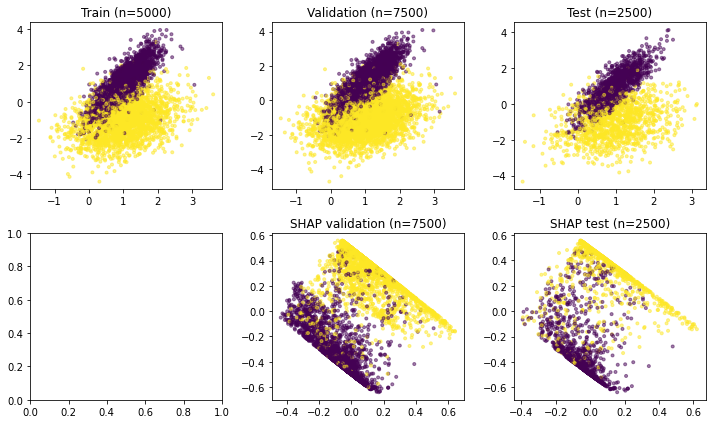

In [111]:
results = shap_linear_separation_test(X, y)

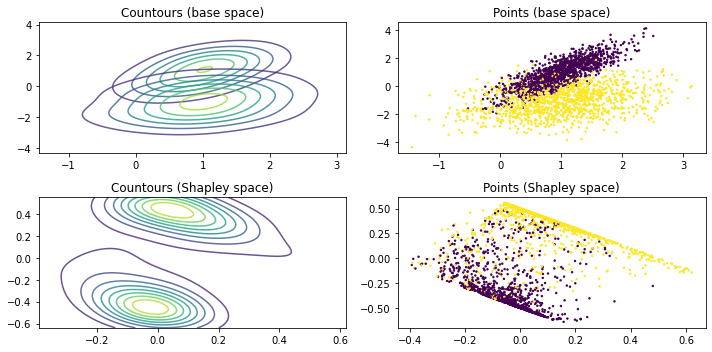

In [126]:
plot_contours(results, kernel='gaussian', bandwith_base=0.5)

In [ ]:
X_test, y_test = results['X_test'], results['y_test']
X_test_shap = results['X_test_shap']

# Example 2

In [100]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2,
                           random_state=10)

Test set performances:
  > Tree model - base space: 0.882
  > Linear model - base space: 0.8596
  > Linear model - SHAP space: 0.8768


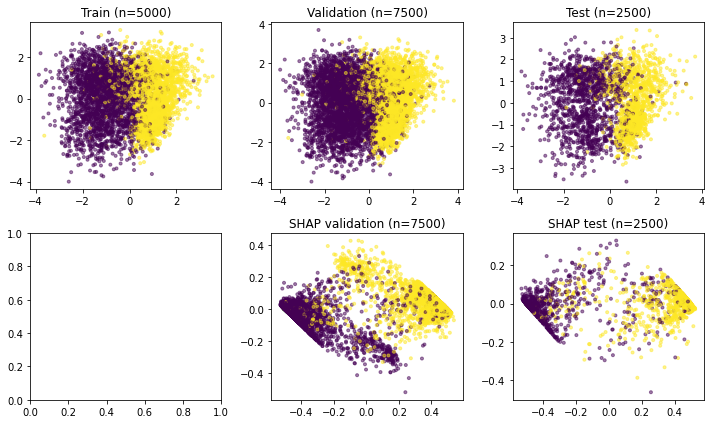

In [101]:
results = shap_linear_separation_test(X, y)

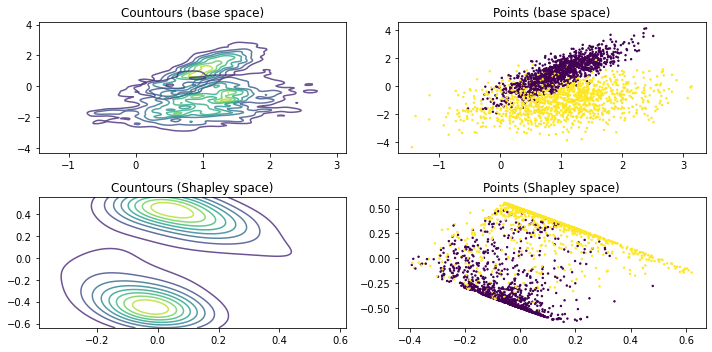

In [138]:
plot_contours(results, kernel='gaussian', bandwith_base=0.1, bandwith_shap=0.1)

# Example 3

In [104]:
X = np.concatenate([
    np.random.multivariate_normal([0.0, 0.0], [[1,0.5],[0.5,1]], size=5000),
    np.random.multivariate_normal([7, 7], [[1,0.0],[0.0,1]], size=5000)
])
y = np.array([1]*5000 + [0]*5000)

Test set performances:
  > Tree model - base space: 1.0
  > Linear model - base space: 1.0
  > Linear model - SHAP space: 1.0


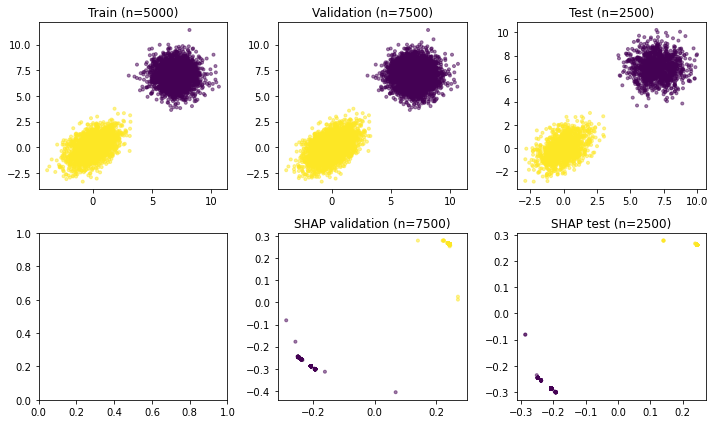

In [108]:
results = shap_linear_separation_test(X, y)

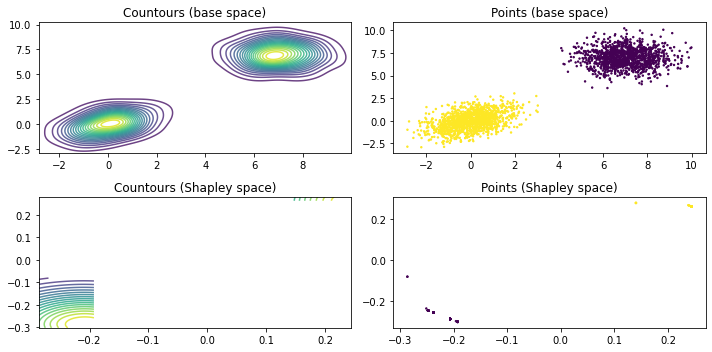

In [109]:
plot_contours(results, kernel='gaussian', bandwith_base=0.5)

# Not being used: Can we use Gaussian classifiers here?

In [3]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

Try first data here:

In [4]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           random_state=1)

Test set performances:
  > Tree model - base space: 0.8956
  > Linear model - base space: 0.8672
  > Linear model - SHAP space: 0.894


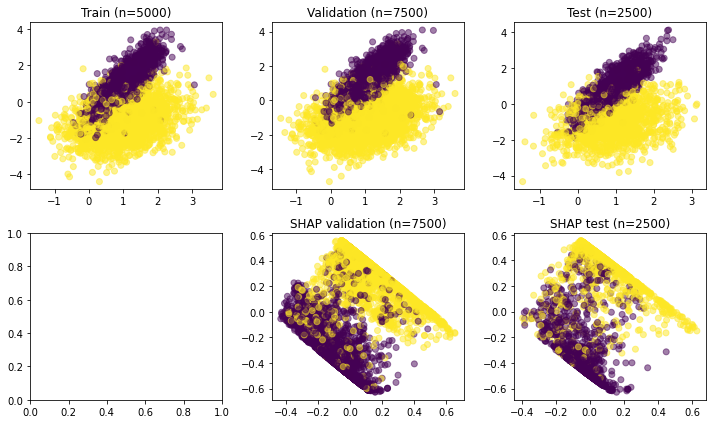

In [7]:
base_model, shap_model = shap_linear_separation_test(X, y, 
                           linear_model1=Perceptron(n_jobs=-1),
                           linear_model2=Perceptron(n_jobs=-1))

# For high dimension

### Example. 1: 10D

In [33]:
%%time
X, y = make_classification(n_samples=10000, n_features=10, n_informative=8, n_redundant=2, n_clusters_per_class=3,
                           random_state=2)

results = shap_linear_separation_test(X, y, 
                           linear_model1=Perceptron(n_jobs=-1),
                           linear_model2=Perceptron(n_jobs=-1),
                           plot=False)

Test set performances:
  > Tree model - base space: 0.9448
  > Linear model - base space: 0.7496
  > Linear model - SHAP space: 0.95
CPU times: user 6min 5s, sys: 2 s, total: 6min 7s
Wall time: 6min 9s


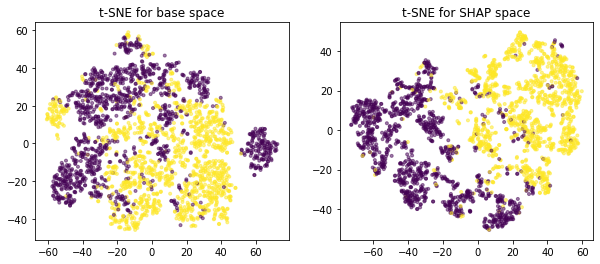

In [34]:
dim_reduc = TSNE(n_components=2, init='pca', random_state=0)

X_base, X_shap, y_test = results['X_test'], results['X_test_shap'], results['y_test']
X_2dim = dim_reduc.fit_transform(X_base)
shap_X_2dim = dim_reduc.fit_transform(X_shap)

fig, ax = plt.subplots(figsize=(10,4), ncols=2)
ax[0].scatter(X_2dim[:,0], X_2dim[:,1], marker='.', alpha=0.5, c=y_test)
ax[0].set_title("t-SNE for base space")
ax[1].scatter(shap_X_2dim[:,0], shap_X_2dim[:,1], marker='.', alpha=0.5, c=y_test)
ax[1].set_title("t-SNE for SHAP space")
plt.show()

### Example 2: 20D

In [35]:
%%time
X, y = make_classification(n_samples=10000, n_features=20, n_informative=16, n_redundant=4, n_clusters_per_class=3,
                           random_state=20)

results = shap_linear_separation_test(X, y, 
                           linear_model1=Perceptron(n_jobs=-1),
                           linear_model2=Perceptron(n_jobs=-1),
                           plot=False)

Test set performances:
  > Tree model - base space: 0.926
  > Linear model - base space: 0.7452
  > Linear model - SHAP space: 0.7992
CPU times: user 11min 23s, sys: 2.56 s, total: 11min 26s
Wall time: 11min 27s


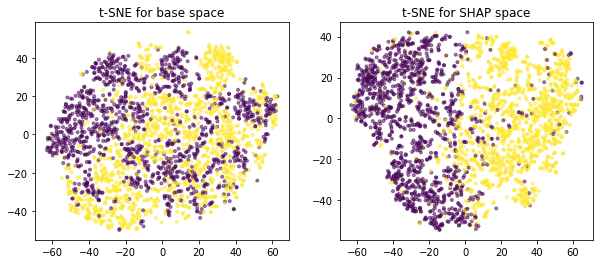

In [36]:
dim_reduc = TSNE(n_components=2, init='pca', random_state=0)

X_base, X_shap, y_test = results['X_test'], results['X_test_shap'], results['y_test']
X_2dim = dim_reduc.fit_transform(X_base)
shap_X_2dim = dim_reduc.fit_transform(X_shap)

fig, ax = plt.subplots(figsize=(10,4), ncols=2)
ax[0].scatter(X_2dim[:,0], X_2dim[:,1], marker='.', alpha=0.5, c=y_test)
ax[0].set_title("t-SNE for base space")
ax[1].scatter(shap_X_2dim[:,0], shap_X_2dim[:,1], marker='.', alpha=0.5, c=y_test)
ax[1].set_title("t-SNE for SHAP space")
plt.show()